In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Set plotting style
%matplotlib inline
plt.style.use('dark_background')

print(f"Seaborn version: {sns.__version__}")

Seaborn version: 0.13.2


In [4]:
# Load the dataset
df = pd.read_csv('TASK3-TRAIN.csv')
print("Initial shape:", df.shape)
df.head()

Initial shape: (58592, 44)


,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


# Data Preprocessing

In [5]:
target = 'ncap_rating'

### Handle missing values

In [6]:
# Handle missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius    

### Check for duplicates

In [7]:

duplicates = df[df.duplicated()]
print("Number of duplicate rows:", len(duplicates))
print(df.shape)

Number of duplicate rows: 0
(58592, 44)


### Encode categorical features

In [8]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  int32  
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  int32  
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  int32  
 8   model                             58592 non-null  int32  
 9   fuel_type                         58592 non-null  int32  
 10  max_torque                        58592 non-null  int32  
 11  max_power                         58592 non-null  int32  
 12  engi

### Correlation

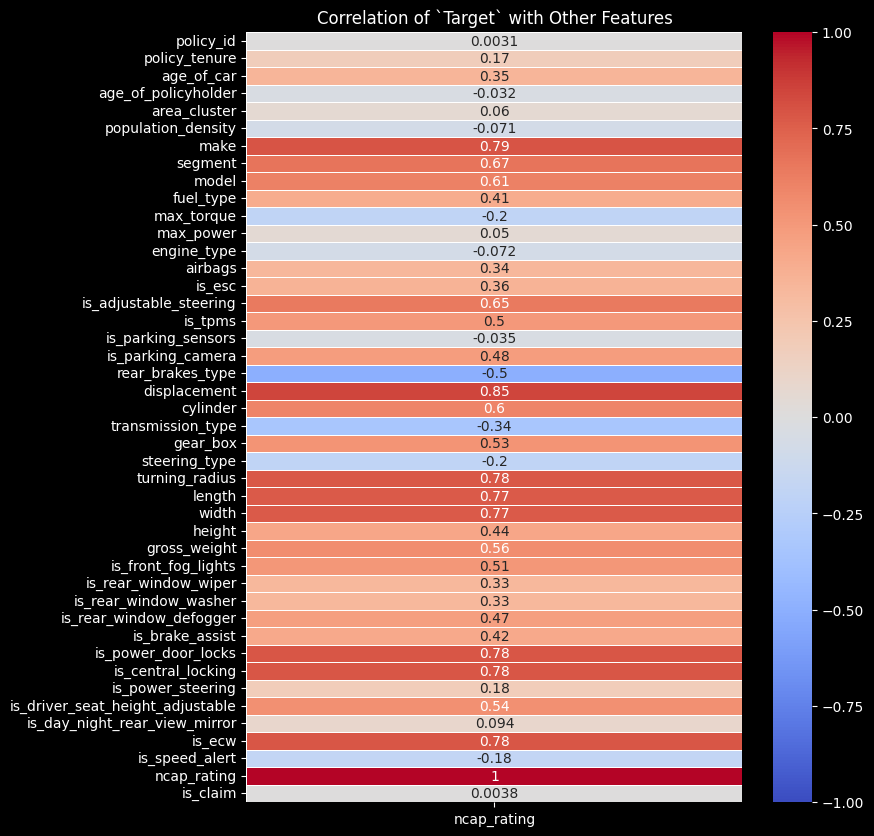

In [9]:
corr_matrix = df.corr()

# Extract the correlation of 'is_claim' with all other columns
target_corr = corr_matrix[[target]]

# Plot the heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation of `Target` with Other Features')
plt.show()

In [10]:
keep_columns = ['is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 
                'is_central_locking', 'is_driver_seat_height_adjustable',
                'airbags', 'segment', 'model', 'fuel_type', 'ncap_rating']
df = df[keep_columns]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   is_rear_window_defogger           58592 non-null  int32
 1   is_brake_assist                   58592 non-null  int32
 2   is_power_door_locks               58592 non-null  int32
 3   is_central_locking                58592 non-null  int32
 4   is_driver_seat_height_adjustable  58592 non-null  int32
 5   airbags                           58592 non-null  int64
 6   segment                           58592 non-null  int32
 7   model                             58592 non-null  int32
 8   fuel_type                         58592 non-null  int32
 9   ncap_rating                       58592 non-null  int64
dtypes: int32(8), int64(2)
memory usage: 2.7 MB


### Handling class imbalance

In [11]:
X = df.drop(columns=[target])
y = df[target]

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
smote = SMOTE()
rus = RandomUnderSampler()
X_resampled, y_resampled = smote.fit_resample(df[keep_columns[:-1]], df[target])

### Split the data into train and test sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Map class 5 to class 1
y_train = np.where(y_train == 5, 1, y_train)
y_test = np.where(y_test == 5, 1, y_test)

print(np.unique(y_train))
print(np.unique(y_test))

[0 1 2 3 4]
[0 1 2 3 4]


# Model Training and Evaluation

### Logistic Regression

In [13]:
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'))
])

param_grid = {
    'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
    'log_reg__penalty': ['l1', 'l2']
}

cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=log_reg_pipeline, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nBest Model Performance:")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'log_reg__C': 0.1, 'log_reg__penalty': 'l1'}
Best Cross-Validation Score: 1.0

Best Model Performance:
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6484
           1       1.00      1.00      1.00      6308
           2       1.00      1.00      1.00      6417
           3       1.00      1.00      1.00      6458
           4       1.00      1.00      1.00      6436

    accuracy                           1.00     32103
   macro avg       1.00      1.00      1.00     32103
weighted avg       1.00      1.00      1.00     32103



### XGBoost

In [14]:
xgb_clf = XGBClassifier(random_state=42, eval_metric='mlogloss', n_estimators=100, early_stopping_rounds=10, use_label_encoder=False, reg_lambda=1, reg_alpha=0.5)
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

C:\Users\Akshat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [23:31:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6484
           1       1.00      1.00      1.00      6308
           2       1.00      1.00      1.00      6417
           3       1.00      1.00      1.00      6458
           4       1.00      1.00      1.00      6436

    accuracy                           1.00     32103
   macro avg       1.00      1.00      1.00     32103
weighted avg       1.00      1.00      1.00     32103



### Evaluate model performance using other metrics

Confusion Matrix:


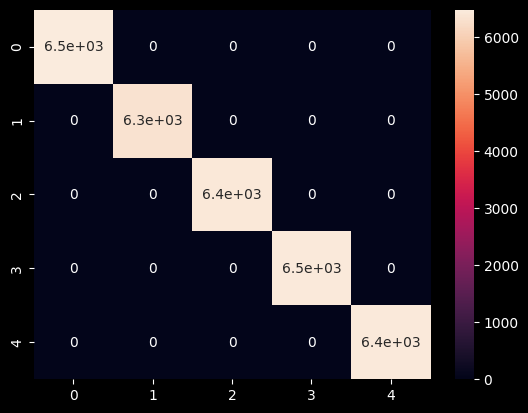

In [15]:
cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True)
plt.show()

# Testing model on Test Data

In [16]:
df_test = pd.read_csv('TASK3-TEST.csv')
print("Test Data shape:", df_test.shape)
df_test.head()

Test Data shape: (39063, 43)


,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
0,ID58593,0.341732,0.00,0.586538,C3,4076,1,A,M1,CNG,...,No,No,No,No,Yes,No,No,No,Yes,0
1,ID58594,0.307241,0.13,0.442308,C8,8794,1,B2,M6,Petrol,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2
2,ID58595,0.327924,0.12,0.451923,C8,8794,2,A,M3,Petrol,...,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2
3,ID58596,0.782654,0.01,0.461538,C5,34738,1,A,M1,CNG,...,No,No,No,No,Yes,No,No,No,Yes,0
4,ID58597,1.233404,0.02,0.634615,C5,34738,1,A,M1,CNG,...,No,No,No,No,Yes,No,No,No,Yes,0
